In [1]:
import numpy as np
import jax 
import optax
import haiku as hk
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context='talk',font_scale=1.0)


import utils

2022-02-15 07:33:54.797365: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/yardenas/.mujoco/mujoco210/bin


## Generate Data

In [3]:
def load_dataset(x_range, b0, w0, n=150, n_tst=150):
    np.random.seed(43)

    def s(x):
        g = (x - x_range[0]) / (x_range[1] - x_range[0])
        return 3 * (0.25 + g**2.)

    x = (x_range[1] - x_range[0]) * np.random.rand(n) + x_range[0]
    eps = np.random.randn(n) * s(x)
    y = (w0 * x * (1. + np.sin(x)) + b0) + eps
    x = x[..., np.newaxis]
    x_tst = np.linspace(*x_range, num=n_tst).astype(np.float32)
    x_tst = x_tst[..., np.newaxis]
    return y.astype(np.float32), x.astype(np.float32), x_tst.astype(np.float32)

def dataset(x, y, batch_size):
    ids = np.arange(len(x))
    while True:
        ids = np.random.choice(ids, batch_size, False)
        yield x[ids].astype(np.float32), y[ids].astype(np.float32)
        
w0 = 0.125
b0 = 5.
x_range = [-20, 60]
batch_size = 32
y, x, x_tst = load_dataset(x_range, b0, w0)
data = iter(dataset(x, y, batch_size))

## Plotting

In [7]:
def plot(x_range, x, y, x_tst, yhats):
    plt.figure(figsize=[15, 4.0], dpi= 100)  # inches
    plt.plot(x, y, 'b.', label='observed')

    avgm = np.zeros_like(x_tst[..., 0])
    for i, yhat in enumerate(yhats):
        m = np.squeeze(yhat.mean())
        s = np.squeeze(yhat.stddev())
        if i < 15:
            plt.plot(x_tst, m, 'r', label='ensemble means' if i == 0 else None, linewidth=1.)
            plt.plot(x_tst, m + 3 * s, 'g', linewidth=0.5, label='ensemble means + 3 ensemble stdev' if i == 0 else None)
            plt.plot(x_tst, m - 3 * s, 'g', linewidth=0.5, label='ensemble means - 3 ensemble stdev' if i == 0 else None)
        avgm += m
    plt.plot(x_tst, avgm / len(yhats), 'r', label='overall mean', linewidth=4)
    plt.ylim(-2, 20)
    plt.yticks(np.linspace(0, 15, 4)[1:])
    plt.xticks(np.linspace(*x_range, num=9))
    ax = plt.gca()
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.spines['left'].set_position(('data', 0))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(0.95, 0.5))
    plt.tight_layout()
    plt.show()

## Train with Bayes-by-Backprop

In [ ]:
from bayes_by_backprop import BayesByBackprop
model = BayesByBackprop(x[:batch_size], 20, utils.net)
opt = optax.flatten(optax.adam(0.01))
keys = hk.PRNGSequence(jax.random.PRNGKey(42))

@jax.jit
def update(x, y, params, key, opt_state):
    grads = model.update_step(params, key, x, y)
    updates, new_opt_state = opt.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state

opt_state = opt.init(model.params)

for step in range(100000):
    model.params, opt_state = update(*next(data), model.params, next(keys),
                                 opt_state)
yhats_bbb = model.predict(x_tst)
plot(x_range, x, y, x_tst, yhats_bbb)

## Train with Functional Particle Optimization

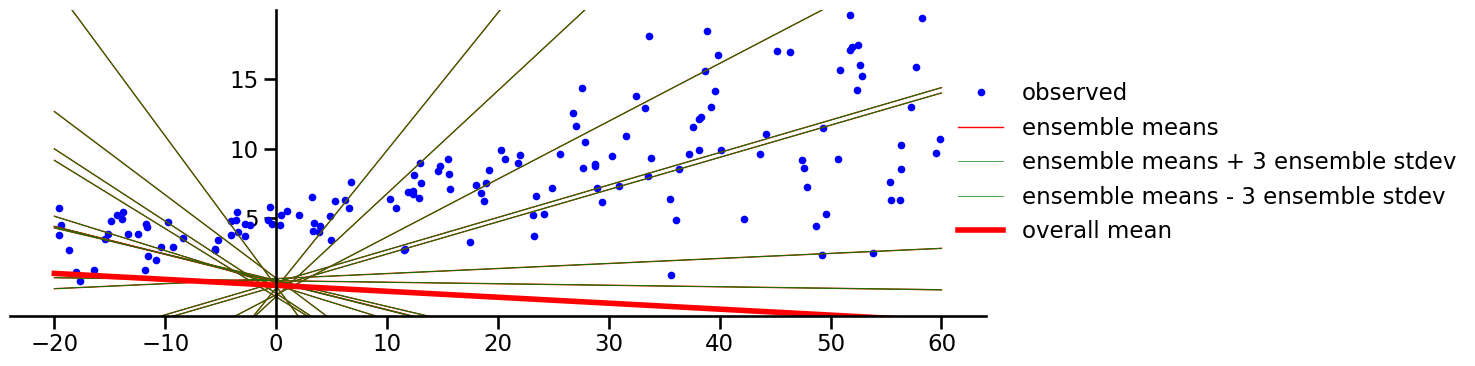

In [9]:
from f_povi import FunctionalParticleOptimization
model = FunctionalParticleOptimization(x[:batch_size], 20, utils.net)
opt = optax.flatten(optax.adam(0.01))
keys = hk.PRNGSequence(jax.random.PRNGKey(42))

@jax.jit
def update(x, y, params, key, opt_state):
    grads = model.update_step(params, key, x, y)
    updates, new_opt_state = opt.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state

opt_state = opt.init(model.params)

for step in range(1000):
    model.params, opt_state = update(*next(data), model.params, next(keys),
                                     opt_state)
yhats_fpovi = model.predict(x_tst)
plot(x_range, x, y, x_tst, yhats_fpovi)